# Data Requirements

Before getting started with DeepSensor, it's important to understand the package's data requirements.
Further details on what DeepSensor supports and does not support are provided below.

DeepSensor **does** support:
* Arbitrary numbers of context sets (or data streams), each with arbitrary numbers of variables (i.e. data channels)
* Spatiotemporal data and static auxiliary data
* Gridded and off-the-grid data
* Moving sensors
* Missing data

DeepSensor **does not** support:
* Data with irregular temporal sampling (i.e. continuous time)

DeepSensor has the following **data requirements**:
* Data formats:
    * Pandas Series/DataFrame (i.e. tabular CSV data)
    * Xarray DataArray/Dataset (i.e. gridded NetCDF data)
* Regular temporal sampling (i.e. hourly, daily, monthly, etc.), which is the same for all variables
* Consistent spatiotemporal dimension names across variables (but arbitrary names are permitted, e.g. `time`, `lat`, `lon`, or `date`, `y`, `x`)
* Each variable has a unique ID, which is used to identify the variable in the model
* Missing data represented by NaNs (i.e., not arbitrary values such as -9999)


## Data Sources

DeepSensor provides several functions in `deepsensor.data.sources` for fetching environmental data in the format expected by the package.
These are not intended as definitive data sources for DeepSensor applications, but rather as a means of demoing and getting started with the package.

The following data sources are currently supported:
* [GHCND](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily): Global Historical Climatology Network Daily (GHCND) station data
* [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview): ERA5 reanalysis data
* [EarthEnv](https://www.earthenv.org/): EarthEnv elevation and Topographic Position Index (TPI) data at various resolutions (1 km, 5 km, 10 km, 50 km, 100 km)
* [GLDAS](https://ldas.gsfc.nasa.gov/gldas/): Global Land Data Assimilation System (GLDAS) 0.25 degree resolution binary land mask

For more details on the data sources, see the API reference for the [data.sources module](../reference/data/sources.rst).

In [2]:
import logging
logging.captureWarnings(True)

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Cache the data in root of docs/ folder, so that other notebook don't need to download it again
cache_dir = "../../.datacache"

In [2]:
from deepsensor.data.sources import get_ghcnd_station_data, get_era5_reanalysis_data, \
    get_earthenv_auxiliary_data, get_gldas_land_mask

In [3]:
data_range = ("2015-06-25", "2015-06-30")
extent = "europe"

### Off-the-grid station data

Off-the-grid station data is data that is not on a regular grid, such as in-situ observations from weather stations.
In DeepSensor, Pandas DataFrames are used to represent off-the-grid station data.
* The variable ID is the column name
* If the DataFrame has multiple columns, each column is treated as a separate variable
* The indexes must be (time, x1, x2), where time is a datetime, and x1 and x2 are the spatial dimensions
* There may be an arbitrary number of additional indexes after these first three indexes. This can be useful for tracking station IDs, for example.

In [4]:
station_var_IDs = ["TAVG", "PRCP"]
station_raw_df = get_ghcnd_station_data(station_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
station_raw_df

PRCP  TAVG
time       lat    lon     station                
2015-06-25 35.017 -1.450  AGM00060531   0.0  23.0
           35.100 -1.850  AGE00147716   0.0  23.4
           35.117  36.750 SYM00040030   NaN  25.4
           35.167  2.317  AGM00060514   0.0  25.9
           35.200 -0.617  AGM00060520   0.0  24.9
...                                     ...   ...
2015-06-30 45.933  7.700  ITM00016052   NaN   5.7
           38.367 -0.500  SPM00008359   0.0  27.6
           55.383  36.700 RSM00027611   0.0  17.2
           59.080  17.860 SWE00138750   0.0   NaN
           63.760  12.430 SWE00140158   0.6   NaN

[16922 rows x 2 columns]

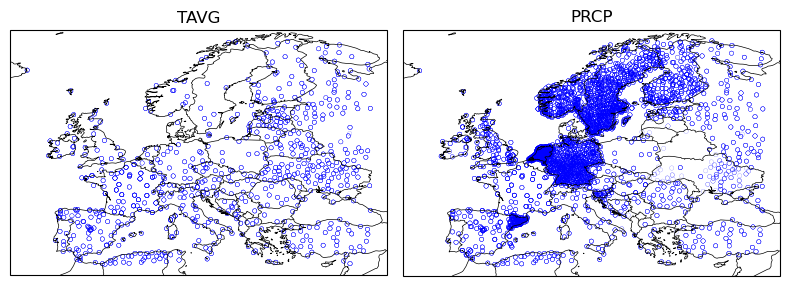

In [5]:
fig, axes = plt.subplots(1, len(station_var_IDs), subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(4 * len(station_var_IDs), 4))
for ax, var_ID in zip(axes, station_var_IDs):
    df = station_raw_df[var_ID].dropna(how="any").reset_index()
    ax.scatter(df.lon, df.lat, transform=ccrs.PlateCarree(), color="b", marker="o", s=10, linewidth=0.1, facecolors='none')
    ax.coastlines(linewidths=0.5)
    ax.add_feature(cfeature.BORDERS, linewidths=0.5)
    ax.set_title(var_ID)
plt.tight_layout()

### Spatiotemporal gridded data

Spatiotemporal gridded data is data that is on a regular spatiotemporal grid, such as reanalysis data or satellite data.
In DeepSensor, Xarray DataArrays/Datasets are used to represent gridded data.
* The variable ID is the variable name in the DataArray/Dataset
* The dimensions must be (time, y, x), where time is a datetime, and y and x are the spatial dimensions

In [6]:
era5_var_IDs = ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind"] 
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
era5_raw_ds 

<xarray.Dataset>
Dimensions:                  (time: 6, lat: 141, lon: 221)
Coordinates:
  * lat                      (lat) float32 70.0 69.75 69.5 ... 35.5 35.25 35.0
  * lon                      (lon) float32 -15.0 -14.75 -14.5 ... 39.75 40.0
  * time                     (time) datetime64[ns] 2015-06-25 ... 2015-06-30
Data variables:
    2m_temperature           (time, lat, lon) float32 274.7 274.8 ... 300.5
    10m_u_component_of_wind  (time, lat, lon) float32 5.999 5.951 ... 4.999
    10m_v_component_of_wind  (time, lat, lon) float32 2.87 2.746 ... -3.017

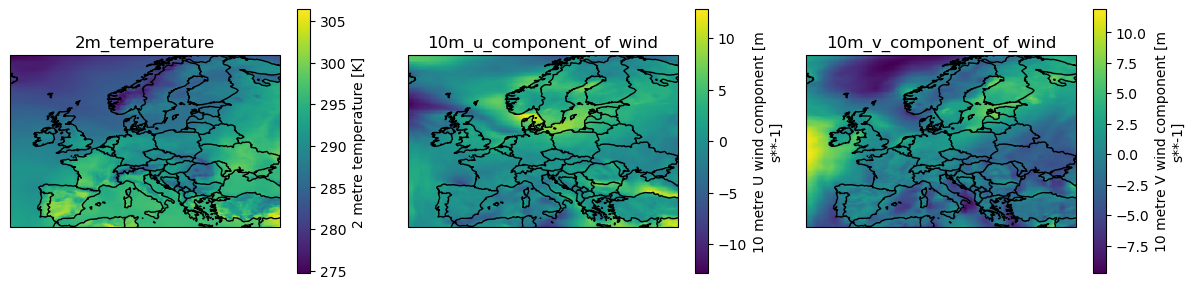

In [7]:
fig, axes = plt.subplots(1, len(era5_var_IDs), subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(4 * len(era5_var_IDs), 3))
for ax, var_ID in zip(axes, era5_var_IDs):
    era5_raw_ds[var_ID].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), center=False, cmap="viridis")
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(var_ID)
plt.tight_layout()

### Static gridded data

We will often want to leverage static variables in our modelling pipelines. 
These static variables may provide information that aid predicting our target variables.
For example, topography will affect surface temperature and soil type will affect soil moisture.
DeepSensor classes support these 'auxiliary' variables with no time dimension.
Here we will download 1 km resolution elevation and Topographic Position Index (TPI) data from EarthEnv, as well as a land mask from GLDAS.

In [8]:
auxiliary_var_IDs = ["elevation", "tpi"]
da = get_earthenv_auxiliary_data(auxiliary_var_IDs, extent, "1KM", cache=True, cache_dir=cache_dir)
da

<xarray.Dataset>
Dimensions:    (lon: 6600, lat: 4200)
Coordinates:
  * lon        (lon) float64 -15.0 -14.99 -14.98 -14.97 ... 39.98 39.99 40.0
  * lat        (lat) float64 70.0 69.99 69.98 69.97 ... 35.03 35.02 35.01 35.0
Data variables:
    elevation  (lat, lon) float32 0.0 0.0 0.0 0.0 ... 260.8 261.6 261.5 260.6
    tpi        (lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.03906 0.07812 0.1641

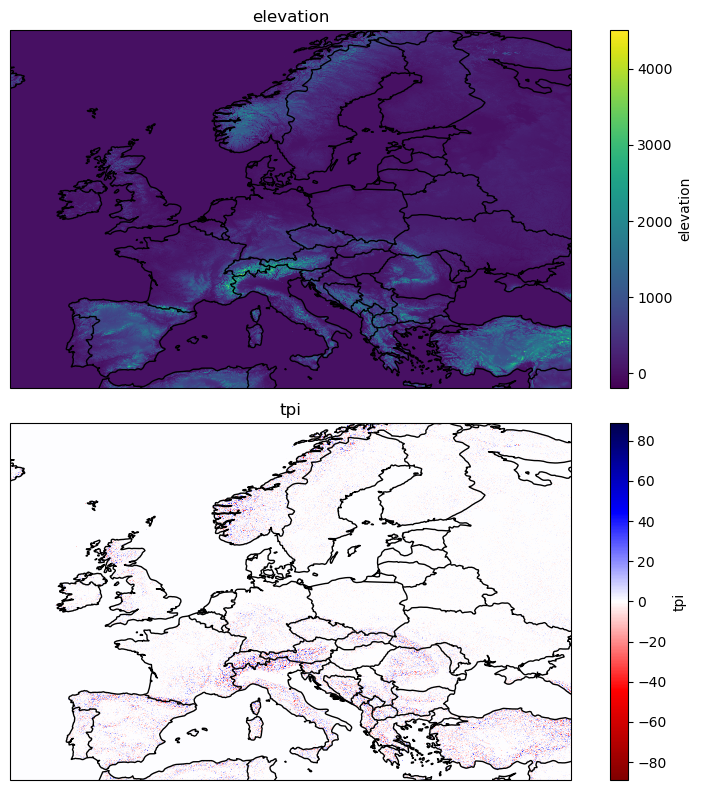

In [9]:
fig, axes = plt.subplots(len(da.data_vars), 1, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 4 * len(da.data_vars)))
for ax, var_ID in zip(axes, da.data_vars):
    if var_ID == "tpi":
        maxabs = max(abs(da[var_ID].min()), abs(da[var_ID].max()))
        da[var_ID].plot(ax=ax, transform=ccrs.PlateCarree(), cmap="seismic_r", vmin=-maxabs, vmax=maxabs)
    else:
        da[var_ID].plot(ax=ax, transform=ccrs.PlateCarree(), center=False, cmap="viridis")
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(var_ID)
plt.tight_layout()

In [10]:
land_da = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir)
land_da

<xarray.DataArray 'GLDAS_mask' (lat: 140, lon: 220)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -14.88 -14.62 -14.38 -14.12 ... 39.38 39.62 39.88
  * lat      (lat) float32 69.88 69.62 69.38 69.12 ... 35.88 35.62 35.38 35.12

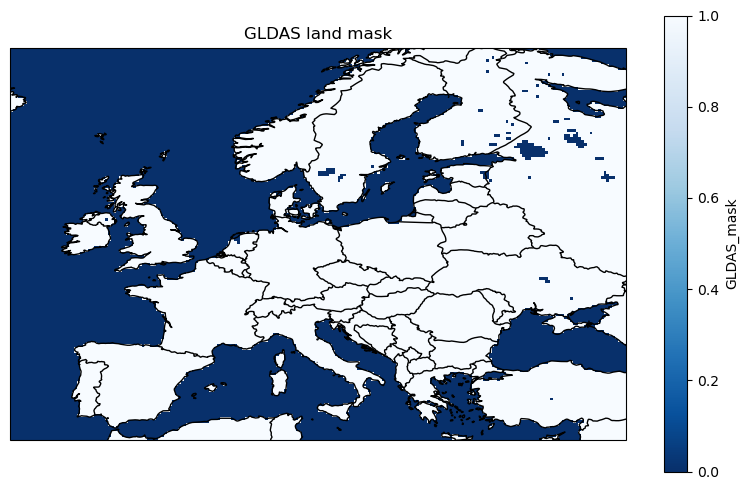

In [11]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 5))
land_da.plot(ax=ax, transform=ccrs.PlateCarree(), center=False, cmap="Blues_r")
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("GLDAS land mask")
plt.tight_layout()